# Automatic autoencoding variational Bayes for latent dirichlet allocation with PyMC3

(c) 2016 by Taku Yoshioka

For probabilistic models with latent variables, autoencoding variational Bayes (AEVB; Kingma and Welling, 2014) is an algorithm which allows us to perform inference efficiently for large datasets with an encoder. In AEVB, the encoder is used to infer variational parameters of approximate posterior on latent variables from given samples. By using tunable and flexible encoders such as multilayer perceptrons (MLPs), AEVB approximates complex variational posterior based on mean-field approximation, which does not utilize analytic representations of the true posterior. Combining AEVB with ADVI (Kucukelbir et al., 2015), we can perform posterior inference on almost arbitrary probabilistic models involving continuous latent variables. 

I have implemented AEVB for ADVI with mini-batch on PyMC3. To demonstrate flexibility of this approach, we will apply this to latent dirichlet allocation (LDA; Blei et al., 2003) for modeling documents. In the LDA model, each document is assumed to be generated from a multinomial distribution, whose parameters are treated as latent variables. By using AEVB with an MLP as an encoder, we will fit the LDA model to the 20-newsgroups dataset. 

In this example, extracted topics by AEVB seem to be qualitatively comparable to those with a standard LDA implementation, i.e., online VB implemented on scikit-learn. Unfortunately, the predictive accuracy of unseen words is less than the standard implementation of LDA, it might be due to the mean-field approximation. However, the combination of AEVB and ADVI allows us to quickly apply more complex probabilistic models than LDA to big data with the help of mini-batches. I hope this notebook will attract readers, especially practitioners working on a variety of machine learning tasks, to probabilistic programming and PyMC3. 

In [1]:
%matplotlib inline

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
import theano
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
from pymc3.variational.advi import advi, sample_vp

theano.config.compute_test_value = 'ignore'

## Dataset
Here, we will use the 20-newsgroups dataset. This dataset can be obtained by using functions of scikit-learn. The below code is partially adopted from an example of scikit-learn (http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html). We set the number of words in the vocabulary to 1000.  

In [2]:
# The number of words in the vocaburary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.428s.
Extracting tf features for LDA...
done in 2.067s.


Each document is represented by 1000-dimensional term-frequency vector. Let's check the data. 

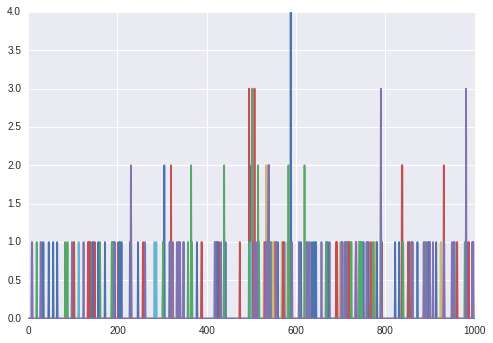

In [3]:
plt.plot(tf[:10, :].toarray().T);

We split the whole documents into training and test sets. The number of tokens in the training set is 480K. Sparsity of the term-frequency document matrix is 0.025%, which implies almost all components in the term-frequency matrix is zero. 

In [4]:
n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 10000
Number of docs for test = 1314
Number of tokens in training set = 480287
Sparsity = 0.0253837


## Log-likelihood of documents for LDA
For a document $d$ consisting of tokens $w$, the log-likelihood of the LDA model with $K$ topics is given as
\begin{eqnarray}
    \log p\left(d|\theta_{d},\beta\right) & = & \sum_{w\in d}\log\left[\sum_{k=1}^{K}\exp\left(\log\theta_{d,k} + \log \beta_{k,w}\right)\right]+const, 
\end{eqnarray}
where $\theta_{d}$ is the topic distribution for document $d$ and $\beta$ is the word distribution for the $K$ topics. We define a function that returns a tensor of the log-likelihood of documents given $\theta_{d}$ and $\beta$. 

In [5]:
def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents. 
    
    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)
    
    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions. 
    theta : tensor (D x K)
        Topic distributions for documents. 
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = vfreqs * pm.math.logsumexp(
            tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
        
        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / tt.sum(vfreqs) * n_tokens 
    
    return ll_docs_f

In the inner function, the log-likelihood is scaled for mini-batches by the number of tokens in the dataset. 

## LDA model
With the log-likelihood function, we can construct the probabilistic model for LDA. `doc_t` works as a placeholder to which documents in a mini-batch are set.  

For ADVI, each of random variables $\theta$ and $\beta$, drawn from Dirichlet distributions, is transformed into unconstrained real coordinate space. To do this, by default, PyMC3 uses a centered stick-breaking transformation. Since these random variables are on a simplex, the dimension of the unconstrained coordinate space is the original dimension minus 1. For example, the dimension of $\theta_{d}$ is the number of topics (`n_topics`) in the LDA model, thus the transformed space has dimension `(n_topics - 1)`. It shuold be noted that, in this example, we use `t_stick_breaking`, which is a numerically stable version of `stick_breaking` used by default. This is required to work ADVI for the LDA model. 

The variational posterior on these transformed parameters is represented by a spherical Gaussian distributions (meanfield approximation). Thus, the number of variational parameters of $\theta_{d}$, the latent variable for each document, is `2 * (n_topics - 1)` for means and standard deviations. 

In the last line of the below cell, `DensityDist` class is used to define the log-likelihood function of the model. The second argument is a Python function which takes observations (a document matrix in this example) and returns the log-likelihood value. This function is given as a return value of `logp_lda_doc(beta, theta)`, which has been defined above. 

In [6]:
n_topics = 10
minibatch_size = 128

# Tensor for documents
doc_t = shared(np.zeros((minibatch_size, n_words)).astype('float32'), name='doc_t')

with pm.Model() as model:
    theta = Dirichlet('theta', a=(1.0 / n_topics) * np.ones((minibatch_size, n_topics)).astype('float32'), 
                      shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9))
    beta = Dirichlet('beta', a=(1.0 / n_topics) * np.ones((n_topics, n_words)).astype('float32'), 
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

Applied stickbreaking-transform to theta and added transformed theta_stickbreaking_ to model.
Applied stickbreaking-transform to beta and added transformed beta_stickbreaking_ to model.


## Mini-batch
To perform ADVI with stochastic variational inference for large datasets, whole training samples are splitted into mini-batches. PyMC3's ADVI function accepts a Python generator which send a list of mini-batches to the algorithm. Here is an example to make a generator.  

TODO: replace the code using the new interface

In [7]:
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        # Return random data samples of a size 'minibatch_size' at each iteration
        ixs = rng.randint(data.shape[0], size=minibatch_size)
        yield [data[ixs]]
        
minibatches = create_minibatch(docs_tr.toarray().astype('float32'))

The ADVI function replaces the values of Theano tensors with samples given by generators. We need to specify those tensors by a list. The order of the list should be the same with the mini-batches sent from the generator. Note that `doc_t` has been used in the model creation as the observation of the random variable named `doc`. 

In [8]:
# The value of doc_t will be replaced with mini-batches
minibatch_tensors = [doc_t]

To tell the algorithm that random variable `doc` is observed, we need to pass them as an `OrderedDict`. The key of `OrderedDict` is an observed random variable and the value is a scalar representing the scaling factor. Since the likelihood of the documents in mini-batches have been already scaled in the likelihood function, we set the scaling factor to 1. 

In [9]:
# observed_RVs = OrderedDict([(doc, n_samples_tr / minibatch_size)])
observed_RVs = OrderedDict([(doc, 1)])

## Encoder
Given a document, the encoder calculates variational parameters of the (transformed) latent variables, more specifically, parameters of Gaussian distributions in the unconstrained real coordinate space. The `encode()` method is required to output variational means and stds as a tuple, as shown in the following code. As explained above, the number of variational parameters is `2 * (n_topics) - 1`. Specifically, the shape of `zs_mean` (or `zs_std`) in the method is `(minibatch_size, n_topics - 1)`. It should be noted that `zs_std` is defined as log-transformed standard deviation and this is automativally exponentiated (thus bounded to be positive) in `advi_minibatch()`, the estimation function. 

To enhance generalization ability to unseen words, a bernoulli corruption process is applied to the inputted documents. Unfortunately, I have never see any significant improvement with this. 

In [10]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds. 
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption
    
    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs], 
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_std = zs[:, (self.n_topics - 1):]
        return zs_mean, zs_std
        
    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

To feed the output of the encoder to the variational parameters of $\theta$, we set an OrderedDict of tuples as below.  

In [11]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, (encoder.encode(doc_t), n_samples_tr / minibatch_size))])

`theta` is the random variable defined in the model creation and is a key of an entry of the `OrderedDict`. The value `(encoder.encode(doc_t), n_samples_tr / minibatch_size)` is a tuple of a theano expression and a scalar. The theano expression `encoder.encode(doc_t)` is the output of the encoder given inputs (documents). The scalar `n_samples_tr / minibatch_size` specifies the scaling factor for mini-batches. 

ADVI optimizes the parameters of the encoder. They are passed to the function for ADVI. 

In [12]:
encoder_params = encoder.get_params()

## AEVB with ADVI
`advi_minibatch()` can be used to run AEVB with ADVI on the LDA model. 

Iteration 0 [0%]: ELBO = -3722434.15
Iteration 100 [10%]: Average ELBO = -3560436.08
Iteration 200 [20%]: Average ELBO = -3491248.54
Iteration 300 [30%]: Average ELBO = -3423979.51
Iteration 400 [40%]: Average ELBO = -3357545.09
Iteration 500 [50%]: Average ELBO = -3313082.75
Iteration 600 [60%]: Average ELBO = -3308812.64
Iteration 700 [70%]: Average ELBO = -3276220.63
Iteration 800 [80%]: Average ELBO = -3284255.9
Iteration 900 [90%]: Average ELBO = -3286331.4
Finished [100%]: ELBO = -3268961.19
CPU times: user 1min 11s, sys: 2.84 s, total: 1min 14s
Wall time: 24 s


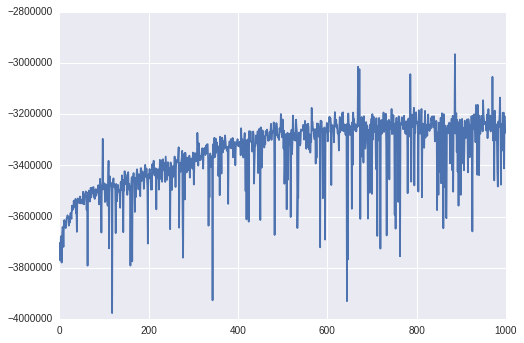

In [13]:
def run_advi():
    with model:
        v_params = pm.variational.advi_minibatch(
            n=1000, minibatch_tensors=minibatch_tensors, minibatches=minibatches, 
            local_RVs=local_RVs, observed_RVs=observed_RVs, encoder_params=encoder_params, 
            learning_rate=5e-2, epsilon=0.1, n_mcsamples=1 
        )
        
    return v_params

%time v_params = run_advi()
plt.plot(v_params.elbo_vals)

We can see ELBO increases as optimization proceeds. The trace of ELBO looks jaggy because at each iteration documents in the mini-batch are replaced. 

## Extraction of characteristic words of topics based on posterior samples
By using estimated variational parameters, we can draw samples from the variational posterior. To do this, we use function `sample_vp()`. Here we use this function to obtain posterior mean of the word-topic distribution $\beta$ and show top-10 words frequently appeared in the 10 topics. 

In [14]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))

doc_t.set_value(docs_te.toarray().astype('float32')[:minibatch_size, :])

with model:
    samples = sample_vp(v_params, draws=100, local_RVs=local_RVs)
    beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: key use government chip law encryption public keys clipper security
Topic #1: years gun states state year mr president weapons united national
Topic #2: edu space com program mail file use information available window
Topic #3: people said world war israel children did armenian jews armenians
Topic #4: thanks windows drive use problem card does dos pc using
Topic #5: 10 year 00 20 15 12 new 11 17 25
Topic #6: don think just know like people going let say ll
Topic #7: god does believe question true jesus people say think point
Topic #8: got time didn good ve did game just like ago
Topic #9: good car new used like power use high work just


We compare these topics to those obtained by a standard LDA implementation on scikit-learn, which is based on an online stochastic variational inference (Hoffman et al., 2013). We can see that estimated words in the topics are qualitatively similar. 

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
%time lda.fit(docs_tr)
beta_sklearn = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

print_top_words(beta_sklearn, feature_names)

CPU times: user 21.7 s, sys: 80 ms, total: 21.7 s
Wall time: 20.8 s
Topic #0: government people law mr president gun state states public rights
Topic #1: drive card scsi bit disk use mac hard memory does
Topic #2: people armenian said armenians turkish did war killed saw russian
Topic #3: year just good time team game car years like think
Topic #4: 10 00 25 15 20 12 11 14 16 17
Topic #5: windows window program dos file use version display ms application
Topic #6: edu space com file information mail data available send ftp
Topic #7: ax max g9v pl b8f a86 34u 145 1t 75u
Topic #8: god people jesus believe does think say life don true
Topic #9: don like know just think ve does use want good


## Predictive distribution
In some papers (e.g., Hoffman et al. 2013), the predictive distribution of held-out words was proposed as a quantitative measure for goodness of the model fitness. The log-likelihood function for tokens of the held-out word can be calculated with posterior means of $\theta$ and $\beta$. The validity of this is explained in (Hoffman et al. 2013). 

In [16]:
def calc_pp(ws, thetas, beta, wix):
    """
    Parameters
    ----------
    ws: ndarray (N,)
        Number of times the held-out word appeared in N documents. 
    thetas: ndarray, shape=(N, K)
        Topic distributions for N documents.         
    beta: ndarray, shape=(K, V)
        Word distributions for K topics. 
    wix: int
        Index of the held-out word
        
    Return
    ------
    Log probability of held-out words.
    """
    return ws * np.log(thetas.dot(beta[:, wix]))

def eval_lda(transform, beta, docs_te, wixs):
    """Evaluate LDA model by log predictive probability. 
    
    Parameters
    ----------
    transform: Python function
        Transform document vectors to posterior mean of topic proportions. 
    wixs: iterable of int
        Word indices to be held-out. 
    """
    lpss = []
    docs_ = deepcopy(docs_te)
    thetass = []
    wss = []
    total_words = 0
    for wix in wixs:
        ws = docs_te[:, wix].ravel()
        if 0 < ws.sum():
            # Hold-out
            docs_[:, wix] = 0
            
            # Topic distributions
            thetas = transform(docs_)
        
            # Predictive log probability
            lpss.append(calc_pp(ws, thetas, beta, wix))
            
            docs_[:, wix] = ws
            thetass.append(thetas)
            wss.append(ws)
            total_words += ws.sum()
        else:
            thetass.append(None)
            wss.append(None)
    
    # Log-probability
    lp = np.sum(np.hstack(lpss)) / total_words
    
    return {
        'lp': lp, 
        'thetass': thetass, 
        'beta': beta, 
        'wss': wss
    }

To apply the above function for the LDA model, we redefine the probabilistic model because the number of documents to be tested changes. Since variational parameters have already been obtained, we can reuse them for sampling from the approximate posterior distribution. 

In [17]:
n_docs_te = docs_te.shape[0]
doc_t = shared(docs_te.toarray().astype('float32'), name='doc_t')

with pm.Model() as model:
    theta = Dirichlet('theta', a=(1.0 / n_topics) * np.ones((n_docs_te, n_topics)).astype('float32'), 
                      shape=(n_docs_te, n_topics), transform=t_stick_breaking(1e-9))
    beta = Dirichlet('beta', a=(1.0 / n_topics) * np.ones((n_topics, n_words)).astype('float32'), 
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

# Encoder has already been trained
encoder.p_corruption = 0
local_RVs = OrderedDict([(theta, (encoder.encode(doc_t), 1))])

Applied stickbreaking-transform to theta and added transformed theta_stickbreaking_ to model.
Applied stickbreaking-transform to beta and added transformed beta_stickbreaking_ to model.


`transform()` function is defined with `sample_vp()` function. This function is an argument to the function for calculating log predictive probabilities. 

In [18]:
def transform_pymc3(docs):
    with model:
        doc_t.set_value(docs)
        samples = sample_vp(v_params, draws=100, local_RVs=local_RVs)
    
    return samples['theta'].mean(axis=0)

The mean of the log predictive probability is -7.51. 

In [19]:
%time result_pymc3 = eval_lda(transform_pymc3, beta_pymc3, docs_te.toarray().astype('float32'), np.arange(100))
print('Predictive log prob (pm3) = {}'.format(result_pymc3['lp']))

CPU times: user 11min 19s, sys: 24.6 s, total: 11min 44s
Wall time: 3min 6s
Predictive log prob (pm3) = -7.354757316807942


We compare the result with the scikit-learn LDA implemented The log predictive probability is significantly higher (-6.04) than AEVB-ADVI, though it shows similar words in the estimated topics. It may because that the mean-field approximation to distribution on the simplex (topic and/or word distributions) is less accurate. See https://gist.github.com/taku-y/f724392bc0ad633deac45ffa135414d3. 

In [20]:
def transform_sklearn(docs):
    thetas = lda.transform(docs)
    return thetas / thetas.sum(axis=1)[:, np.newaxis]

%time result_sklearn = eval_lda(transform_sklearn, beta_sklearn, docs_te.toarray(), np.arange(100))
print('Predictive log prob (sklearn) = {}'.format(result_sklearn['lp']))

CPU times: user 44.8 s, sys: 540 ms, total: 45.4 s
Wall time: 44.4 s
Predictive log prob (sklearn) = -6.041000209921997


# Summary
We have seen that PyMC3 allows us to estimate random variables of LDA, a probabilistic model with latent variables, based on automatic variational inference. Variational parameters of the local latent variables in the probabilistic model are encoded from observations. The parameters of the encoding model, MLP in this example, are optimized with variational parameters of the global latent variables. Once the probabilistic and the encoding models are defined, parameter optimization is done just by invoking a function (`advi_minibatch()`) without need to derive complex update equations. 

Unfortunately, the estimation result was not accurate compared to LDA in sklearn, which is based on the conjugate priors and thus not relying on the mean field approximation. To improve the estimation accuracy, some researchers proposed post processings that moves Monte Carlo samples to improve variational lower bound (e.g., Rezende and Mohamed, 2015; Salinams et al., 2015). By implementing such methods on PyMC3, we may achieve more accurate estimation while automated as shown in this notebook. 

# References
* Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. stat, 1050, 1.
* Kucukelbir, A., Ranganath, R., Gelman, A., & Blei, D. (2015). Automatic variational inference in Stan. In Advances in neural information processing systems (pp. 568-576).
* Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
* Hoffman, M. D., Blei, D. M., Wang, C., & Paisley, J. W. (2013). Stochastic variational inference. Journal of Machine Learning Research, 14(1), 1303-1347.
* Rezende, D. J., & Mohamed, S. (2015). Variational inference with normalizing flows. arXiv preprint arXiv:1505.05770.
* Salimans, T., Kingma, D. P., & Welling, M. (2015). Markov chain Monte Carlo and variational inference: Bridging the gap. In International Conference on Machine Learning (pp. 1218-1226).